In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
import json
from fbprophet.serialize import model_to_json, model_from_json
import warnings
warnings.filterwarnings('ignore')

- the outliers in data are removed before by analyzing std and mean of a particular window.
- Now,to remove sudden increase in prices we smoothened the curve by taking moving average.
- We split the data into traning data(total_length-14) + validation_data(7days) + test_data(7 days)

In [4]:
#data Processing
VEGETABLE= 'pointed_gourd'
df = pd.read_csv("./data/"+VEGETABLE+'_NO_OUTLIERS.csv')
df = df.drop(['Unnamed: 0'], axis= 1)
df['DATE'] = df['DATE'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
df['MODAL'] = df['MODAL'].apply(lambda x: float(x))
df = df.set_index('DATE')
df = df.rolling(7).mean()
df = df.reset_index()
df.columns = ['ds','y']
df = df.sort_values(by=['ds'])
train_data = df[:-609] #2010-2018
validation_data = df[-609:-244] #2019
test_data = df[-244:] #2020
train_validation_df = pd.concat([train_data, validation_data])


In [5]:
#model
m = Prophet()
m.fit(train_data)
future = m.make_future_dataframe(periods=609)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


- modification of forecast values predicted by prophet by checking the error produced in previous week

In [6]:
def validate(C1, C2, C, D, forecast, df):
    f2 = forecast.copy()
    f2['orj'] = pd.Series(df['y'].to_numpy())
    for i in range(1, len(forecast)//7-7):
        cnt = 0
        upp = 0
        low = 0
        for j in range((i-1)*7, (i)*7):
            if abs(forecast['yhat_lower'][j]-forecast['yhat_upper'][j])*C1 < abs(forecast['yhat'][j]-df['y'][j]):
                cnt += 1
            if forecast['yhat'][j]-df['y'][j] < 0:
                upp += 1
            else: low += 1
        if cnt >= C2:
            for j in range((i)*7, (i+1)*7):

                f2['yhat'][j] = C[0] * forecast['yhat'][j] + C[1] * f2['yhat'][j-7] + C[2] * df['y'][j-7] 
                if upp > low:
                    f2['yhat'][j] += D[0] * forecast['yhat_upper'][j] + D[1] * forecast['yhat_upper'][j-7]
                else:
                    f2['yhat'][j] += D[0] * forecast['yhat_lower'][j] + D[1] * forecast['yhat_lower'][j-7]
    
    f2['sqe'] = (f2['yhat'] - f2['orj'])**2
    return f2

def calc_train_remse(f2):
    return (f2['sqe'][:-609].sum()/(len(f2['sqe'])-609))**(1/2)
def calc_validation_rmse(f2):
    return (f2['sqe'][-609:-244].sum()/365)**(1/2)
def cal_test_rmse(f2):
    return (f2['sqe'][-244:].sum()/244)**(1/2)

X1 = np.linspace(0.1, 1, num=10)
X2 = np.linspace(0.1, 1, num=10)
X3 = np.linspace(0.1, 1, num=10)
D1 = [0.1,0.2,0.3]
D2 = [0.1,0.2,0.3]
counter = 0
validation_rmses = []
forecasts = []
for d1 in D1:
    for d2 in D2:    
        for x1 in X1:
            for x2 in X2:
                for x3 in X3:
                        if x1+x2+x3+d1+d2!=1:
                            continue
                        forecasts.append(validate(0.25,3,[x1,x2,x3],[d1,d2], forecast, df))
                        validation_rmses.append(([x1,x2,x3],[d1,d2],calc_validation_rmse(forecasts[-1])))
                        
                        
validation_rmses.sort(key= lambda x: x[2])
validation_rmses[:10]


[([0.2, 0.1, 0.5], [0.1, 0.1], 667.8061890567593),
 ([0.2, 0.1, 0.4], [0.1, 0.2], 678.1205641998463),
 ([0.30000000000000004, 0.1, 0.4], [0.1, 0.1], 679.0019823418935),
 ([0.1, 0.1, 0.6], [0.1, 0.1], 680.0965287494934),
 ([0.1, 0.1, 0.5], [0.1, 0.2], 685.7803592342693),
 ([0.2, 0.1, 0.30000000000000004], [0.2, 0.2], 689.2451407229232),
 ([0.1, 0.1, 0.4], [0.2, 0.2], 689.5145113385548),
 ([0.2, 0.2, 0.4], [0.1, 0.1], 689.9143123528016),
 ([0.2, 0.1, 0.30000000000000004], [0.1, 0.3], 691.3567077289714),
 ([0.30000000000000004, 0.1, 0.30000000000000004],
  [0.1, 0.2],
  693.5741245362742)]

In [15]:
selected_forecast = validate(0.25,3, [0.2, 0.1, 0.5], [0.1, 0.1], forecast, df)
test_rmse = cal_test_rmse(selected_forecast)
print("TEST RMSE: ", test_rmse)

TEST RMSE:  934.4452932484122


In [16]:
plot_plotly(m, selected_forecast)

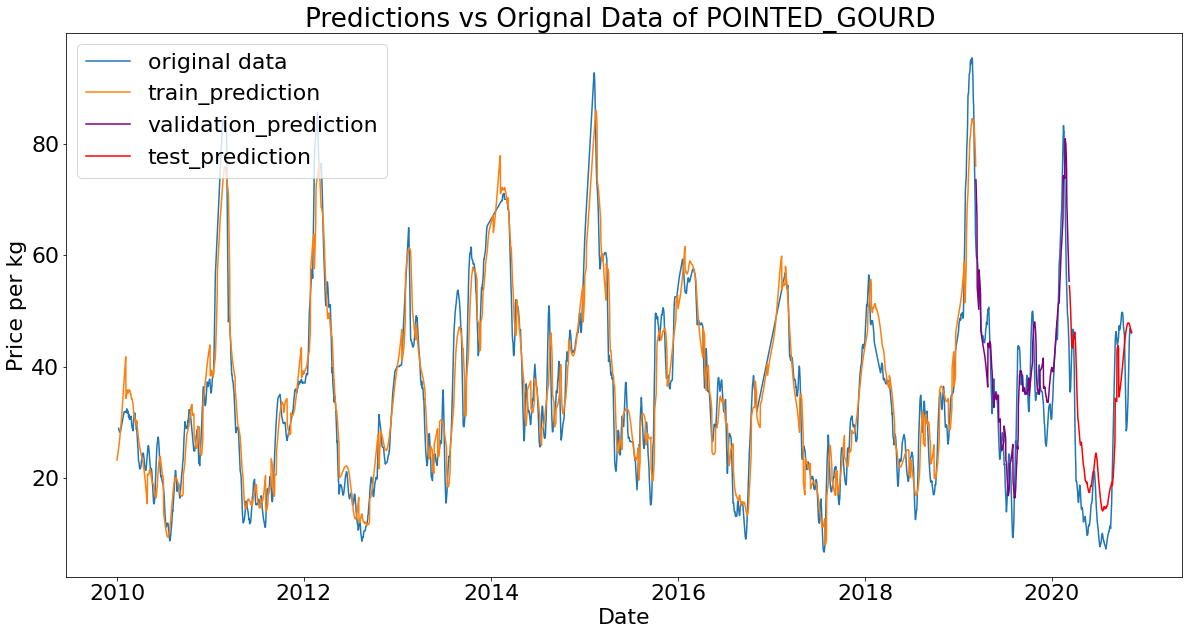

In [17]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 22})
plt.plot(df['ds'], df['y']/100, label= "original data")
plt.plot(df['ds'][:-609], selected_forecast['yhat'][:-609]/100, label= "train_prediction")
plt.plot(selected_forecast['ds'][-609:-244], selected_forecast['yhat'][-609:-244]/100, color= 'purple', label= "validation_prediction")
plt.plot(selected_forecast['ds'][-244:], selected_forecast['yhat'][-244:]/100, color= 'red', label= "test_prediction")
plt.legend(loc="upper left")
plt.title("Predictions vs Orignal Data of POINTED_GOURD ")
plt.xlabel("Date")
plt.ylabel("Price per kg")
plt.show()

In [13]:
#prediction on model trained on 2010-2018 data
prediction_future = m.make_future_dataframe(periods=609)
final_forecast = m.predict(prediction_future)
final_forecast = validate(0.25,3, [0.1, 0.1, 0.6], [0.1, 0.1], final_forecast, df)


In [14]:
future_prediction_values = final_forecast['yhat'][-7:]